## Definition des dépendances

Dans un premier temps nous allons importer l'ensemble des bibliothèques à utiliser 

In [1]:
import librosa
import librosa.display 
import IPython.display as ipd
import numpy as np
import glob
import matplotlib.pyplot as plt 
import random 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
import IPython.display as ipd
import noisereduce as nr
import datetime

2024-06-15 18:30:05.710359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/macbookpro/miniforge3/envs/tensorflow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['image.cmap'] = 'gray'

En suite nous initialisons les variables que nous allons utiliser tout le long du projet :
- AUDIO_PATH : Qui est une expression réguliere du chemin vers tous fichiers .wav que nous allons utiliser
- files : Qui est une liste générée par glob qui contient le chemain d'accès de chaque fichier
- audios : Une liste qui va contenir l'ensemble des audios
- labels : Une liste qui va contenir l'ensemble des labels de chaque audio
- all_SR : Ici on va stocker les sample rate de chaque audio
- clean_audios : Où sera stocké les audios après traitement (normalisation, extraction des moments de silence)
- mfcc_audios : On va stocker dans cette liste les résultats du calcul des MFCC de chaque audio

In [3]:
AUDIO_PATH='all_data/*/*.wav'
files = glob.glob(AUDIO_PATH)
audios=[]
labels=[]
all_SR=[]
clean_audios =[]
clean_audios2 =[]
mfcc_audios =[]
mfcc_audios2=[]
FIG_SIZE=[20,15]

## Importation des données et visualisation

Lecture des audios et des labels
Les données sont organisées dans des dossiers. Chaque dossier correspond au label de l'audio.    

In [4]:
#Mettre les audios en desordre
random.seed(42)
random.shuffle(files)
for file in files:#Pour chaque fichier dans la liste des fichiers 
    try :
        x, sample_rate=librosa.load(file)#On charge l'audio du fichiers et son sample rate
        audios.append(x)#On stocke l'audio
        all_SR.append(sample_rate)#On stocke le sample rate
        labels.append(file.split("/")[-2])#On extrait le label dans le path du fichier
    except :
        print(file)
print(""".
└── all_data
    ├── 0
        └─  *.wav
    ├── 1
        └─  *.wav
    ├── 2
        └─  *.wav
    ├── 3
        └─  *.wav
    ├── 4
        └─  *.wav
    ├── 5
        └─  *.wav
    ├── 6
        └─  *.wav
    ├── 7
        └─  *.wav
    ├── 8
        └─  *.wav
    └── 9
        └─  *.wav""")

.
└── all_data
    ├── 0
        └─  *.wav
    ├── 1
        └─  *.wav
    ├── 2
        └─  *.wav
    ├── 3
        └─  *.wav
    ├── 4
        └─  *.wav
    ├── 5
        └─  *.wav
    ├── 6
        └─  *.wav
    ├── 7
        └─  *.wav
    ├── 8
        └─  *.wav
    └── 9
        └─  *.wav


In [5]:
ipd.Audio(audios[1], rate=all_SR[1])

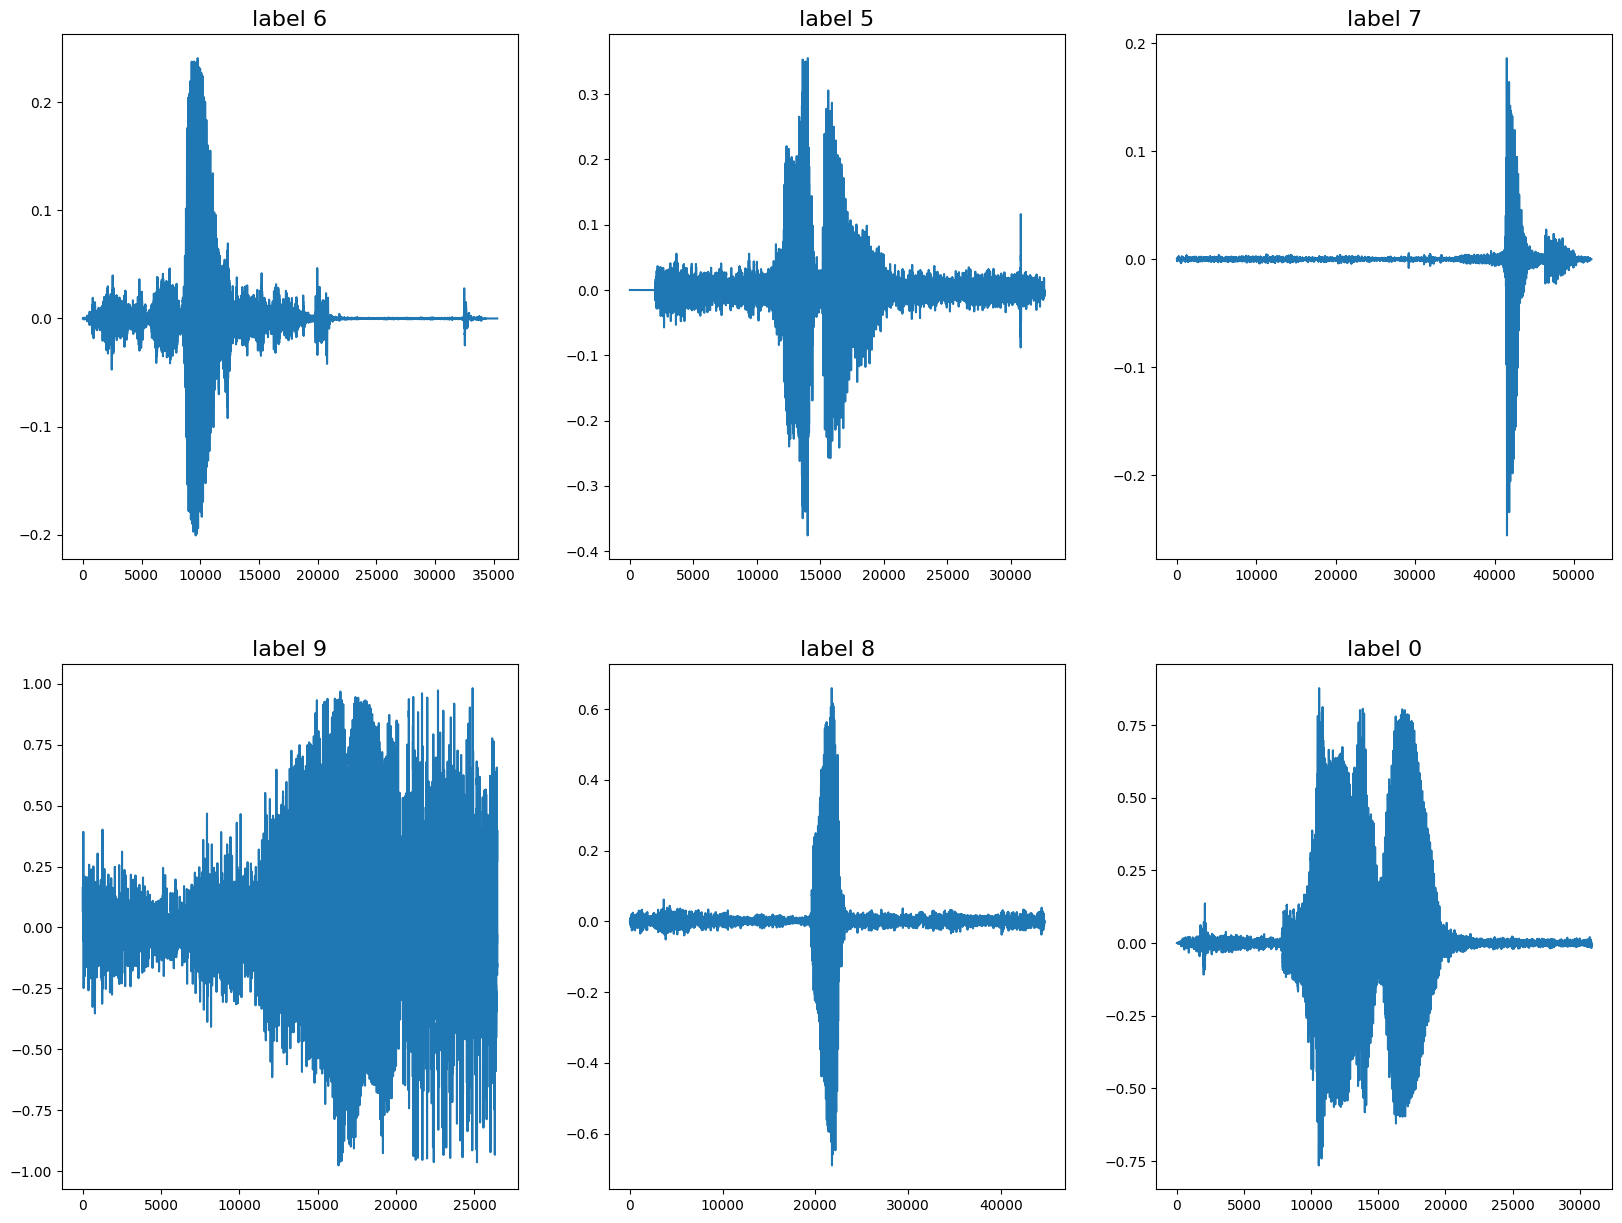

In [6]:
#Visualisation de certains audios 
num=6 
plt.figure(figsize=FIG_SIZE)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(audios[i])
    plt.title(f"label {labels[i]}")

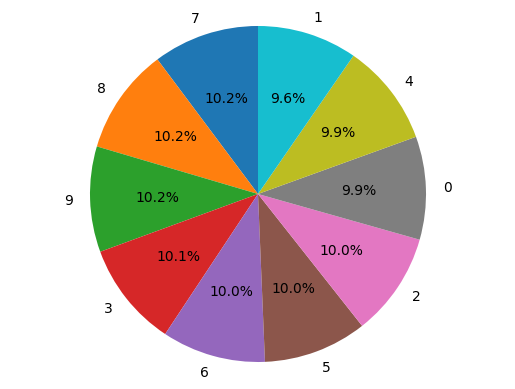

In [7]:
#Distribution des labels dans les données
import pandas as pd 
labels_count=pd.Series(labels).value_counts()
fig, ax = plt.subplots()
ax.pie(labels_count, labels=labels_count.index, startangle=90, 
       autopct='%1.1f%%')
ax.axis('equal')
plt.show()


## Traitement des audios 

On met en place un prétraitement des audios qui va consister à :
1. Retirer les moments de silence dans les audios pour ne garder que les parties où le locuteur prononce le chiffre
2. Supprimer les bruits dans l'audio
3. Normaliser l'audio c-a-d ramener les signaux entres -1 et 1

Pour ce qui est de l'élimination des moments de silence, nous avons deux approches chacune avec ses avantages et ses inconvenients lors de la construction du modèle :
- **Élimination du silence au début et à la fin** : Cette approche peut être utile lorsque les moments de silence au début et à la fin de l'audio n'apportent pas d'informations pertinentes pour la classification. Par exemple, dans la reconnaissance de la parole ou la détection des émotions, les moments de silence au début et à la fin peuvent ne pas contenir d'informations utiles et leur élimination peut aider à réduire la dimensionnalité des données sans perdre d'informations importantes¹.

- **Élimination du silence sur tout l'audio** : Cette approche peut être plus radicale car elle élimine tous les moments de silence dans l'audio, y compris ceux qui peuvent se produire au milieu de l'audio. Dans certains cas, cela peut être bénéfique, par exemple, si le silence n'est pas informatif pour la tâche de classification. Cependant, dans d'autres cas, cela pourrait supprimer des informations importantes. Par exemple, dans la reconnaissance de la parole, les pauses (silence) entre les mots peuvent contenir des informations importantes sur la structure de la phrase.

Dans le cadre de ce projet, nous allons implémenter les deux approches de traitement et comparer les performances des deux modèles


In [8]:
def extract_silence_StartEnd(audio, sr):
    # Extract a noise profile (first 1 second if it contains only noise)
    noise_profile = audio[:sr]  # Assuming the first second is noise
    # Perform noise reduction using the noise profile
    reduced_noise = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_profile)
    #Retirer les moments de silence en debut et à la fin de l'audio
    audio_trim,_=librosa.effects.trim(reduced_noise, top_db=20)
    #Normaliser l'audio
    clean_audio = librosa.util.normalize(audio_trim)
    return clean_audio

In [9]:
def extract_silence_AllAudio(audio, sr):
    # Extract a noise profile (first 1 second if it contains only noise)
    noise_profile = audio[:sr]  # Assuming the first second is noise
    # Perform noise reduction using the noise profile
    reduced_noise = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_profile)
    intervalles = librosa.effects.split(reduced_noise, top_db=20) # Identifier les intervalles de non silence dans un audio
    audio_trim = np.concatenate([reduced_noise[debut:fin] for debut, fin in intervalles]) #Retirer les moment de silence 
    #Normaliser l'audio
    clean_audio = librosa.util.normalize(audio_trim)
    
    return clean_audio

In [10]:
#On applique le traitement à tous les audios 
for i, audio in enumerate(audios):
    audio_copy=audio.copy()
    clean_audios.append(extract_silence_StartEnd(audio_copy, all_SR[i]))

In [11]:
ipd.Audio(clean_audios[1], rate=all_SR[1])

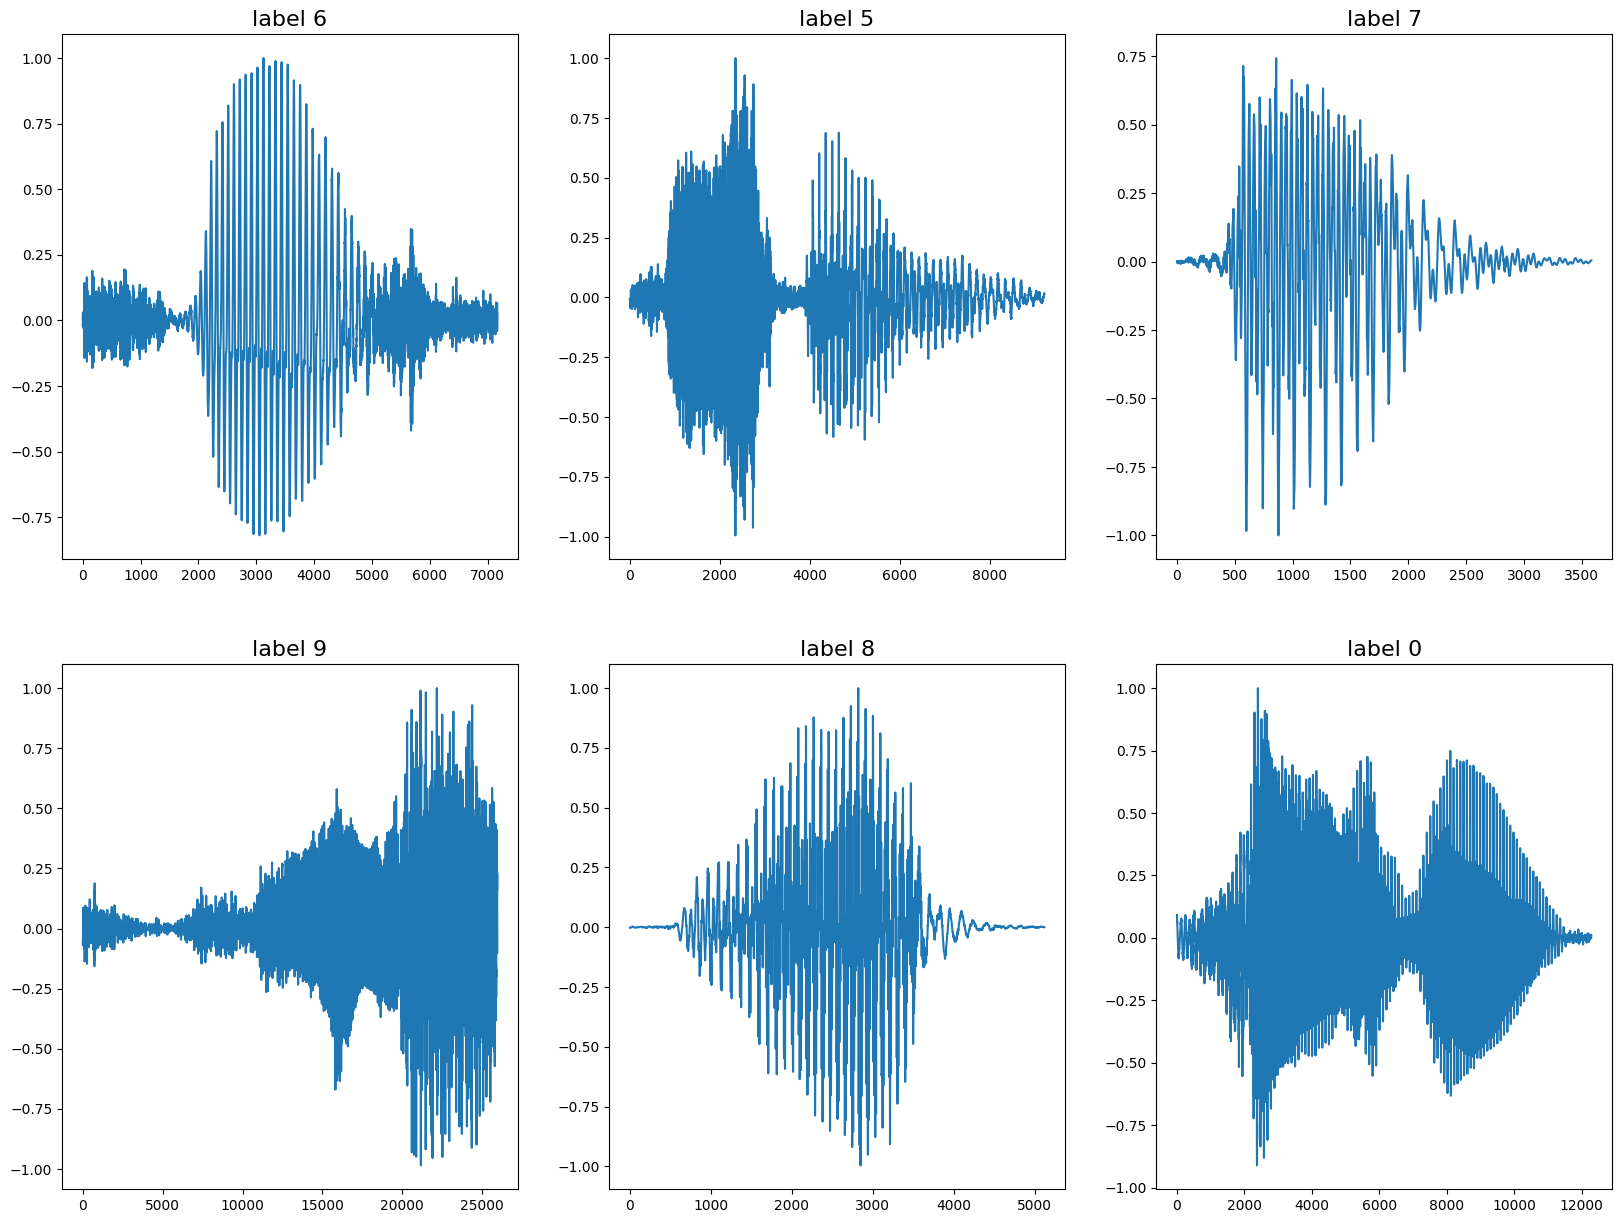

In [12]:
#On visualise le résultat 
num=6 
plt.figure(figsize=FIG_SIZE)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(clean_audios[i])
    plt.title(f"label {labels[i]}")

In [13]:
#On applique le traitement à tous les audios 
for i, audio in enumerate(audios):
    audio_copy=audio.copy()
    clean_audios2.append(extract_silence_AllAudio(audio_copy, all_SR[i]))

In [14]:
ipd.Audio(clean_audios2[1], rate=all_SR[1])

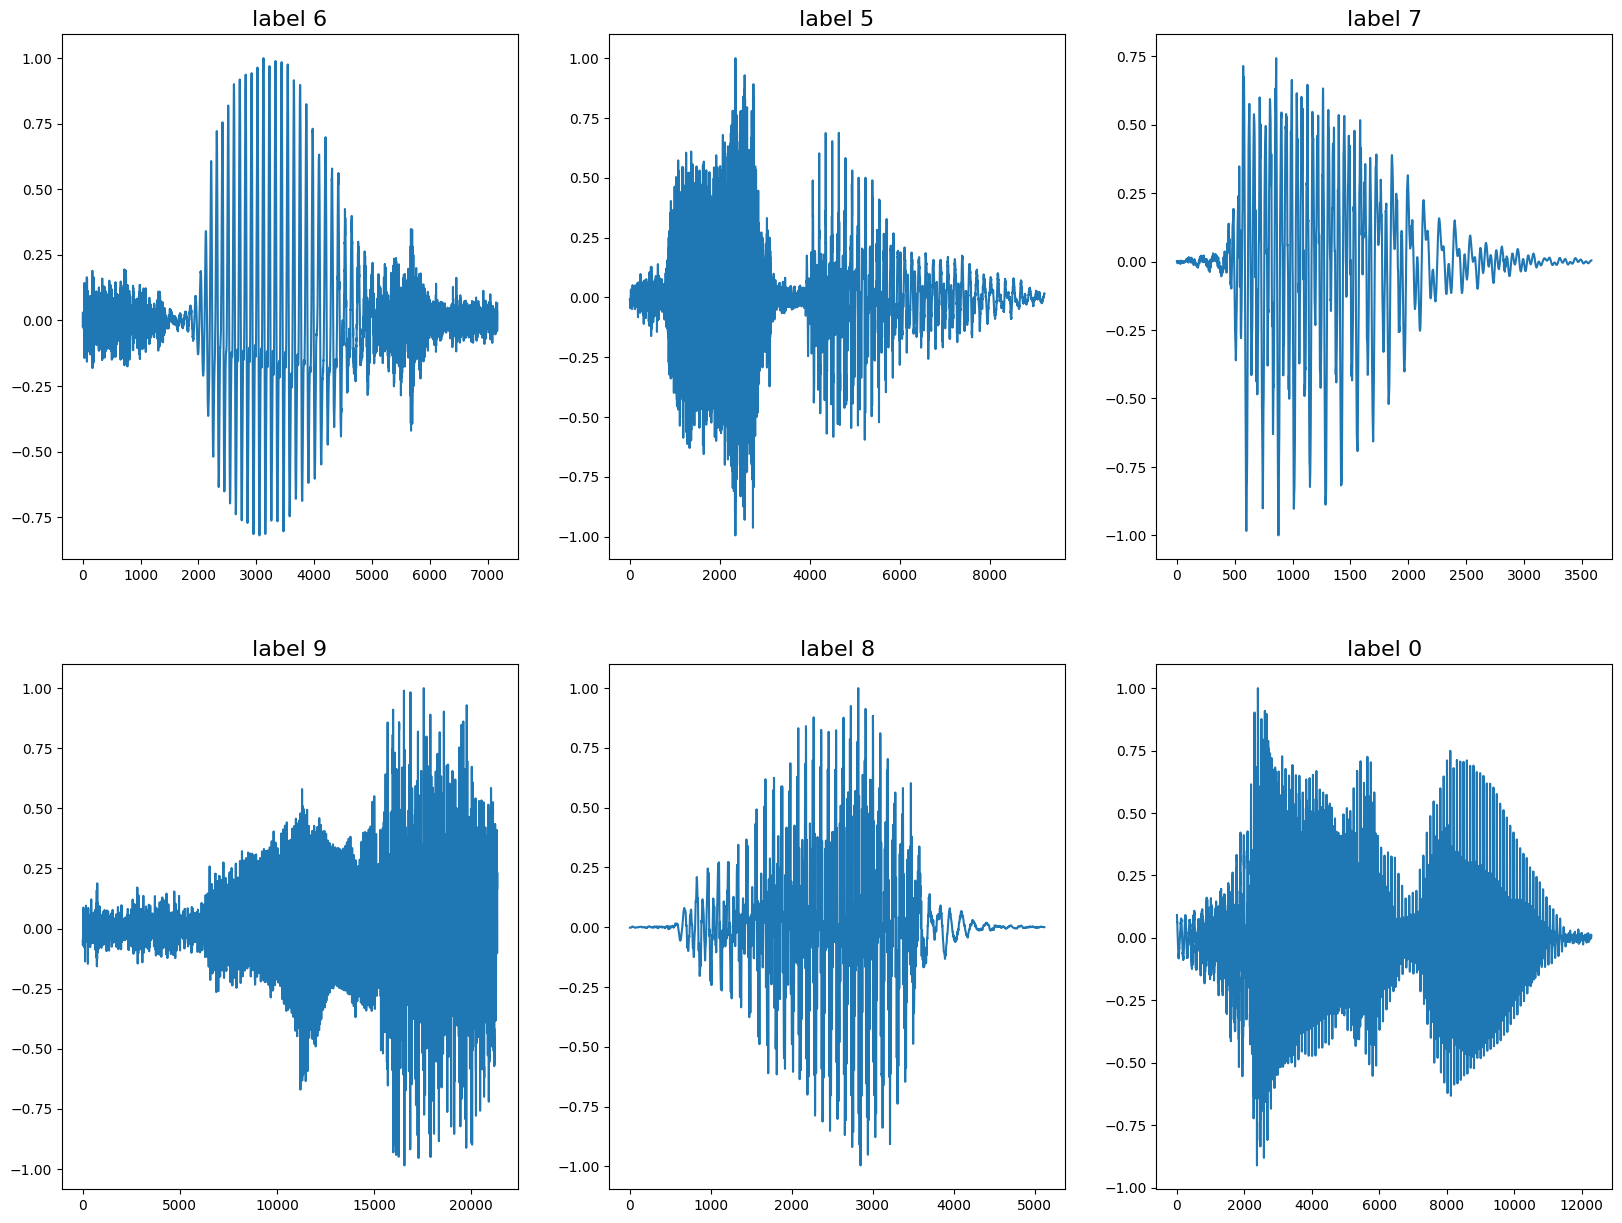

In [15]:
#On visualise le résultat 
num=6 
plt.figure(figsize=FIG_SIZE)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(clean_audios2[i])
    plt.title(f"label {labels[i]}")

## Extraction des caractéristiques des audios avec MFCC

La prochaine étape va consister à appliquer le Mel-Frequency Cepstral Coefficients (MFCC) a chaque audio traité pour extraire les caractéristiques qui serons utilisé par la suite dans le processus de modélisation\
**Note :** Nous allons prendre pour cette extraction, 20 coefficients pour le MFCC. En se basant sur l'[article](https://www.nature.com/articles/s41598-023-49869-6.pdf) *A novel hybrid model integrating MFCC and acoustic parameters for voice disorder detection* de *VyomVerma et al*  où il est dit que c'est une représentation largement utilisée pour caractériser le contenu spectral des signaux vocaux.

In [16]:
for audio in clean_audios:
    audio_copy=audio.copy()
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
    mfcc_audios.append(mfcc)

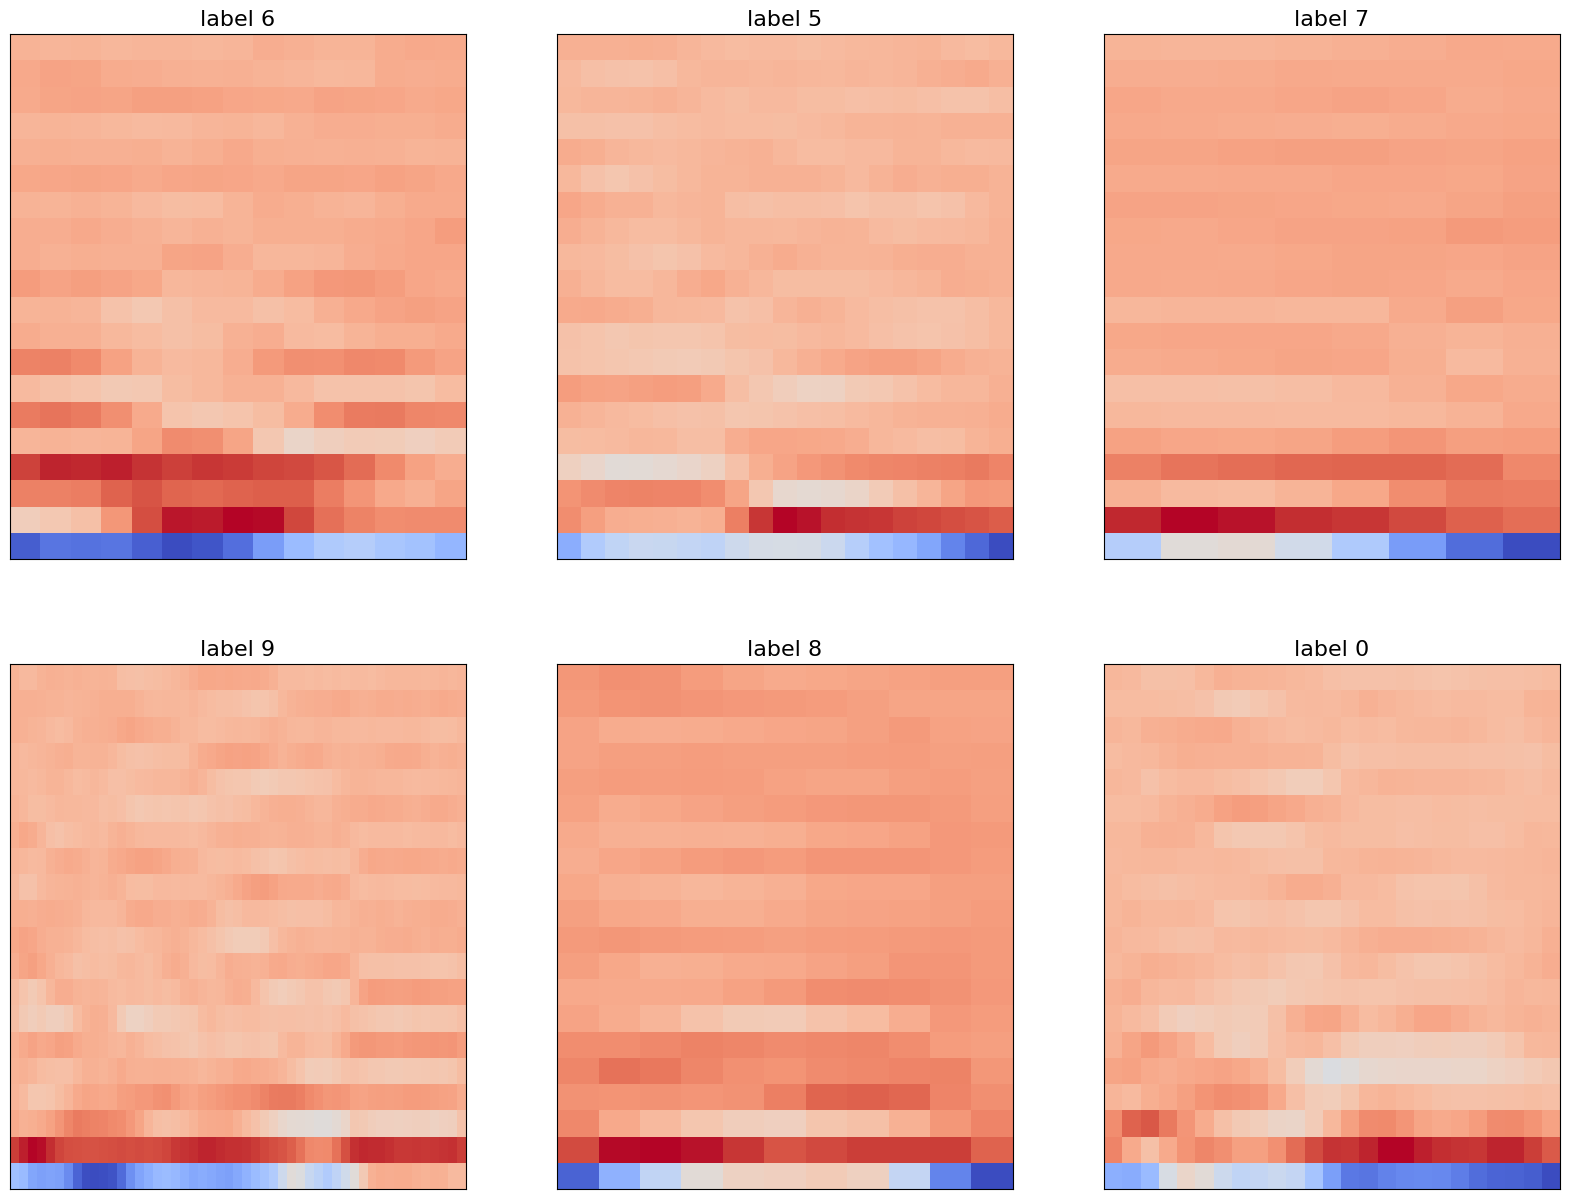

In [17]:
#On visualise le resultat du MFCC
num=6 
plt.figure(figsize=FIG_SIZE)
for i in range(6):
    plt.subplot(2,3,i+1)
    librosa.display.specshow(mfcc_audios[i])
    plt.title(f"label {labels[i]}")

In [18]:
mfcc_audios[0].shape, mfcc_audios[1].shape

((20, 15), (20, 19))

In [19]:
for audio in clean_audios2:
    audio_copy=audio.copy()
    mfcc = librosa.feature.mfcc(y=audio_copy, sr=sample_rate, n_mfcc=20)
    mfcc_audios2.append(mfcc)

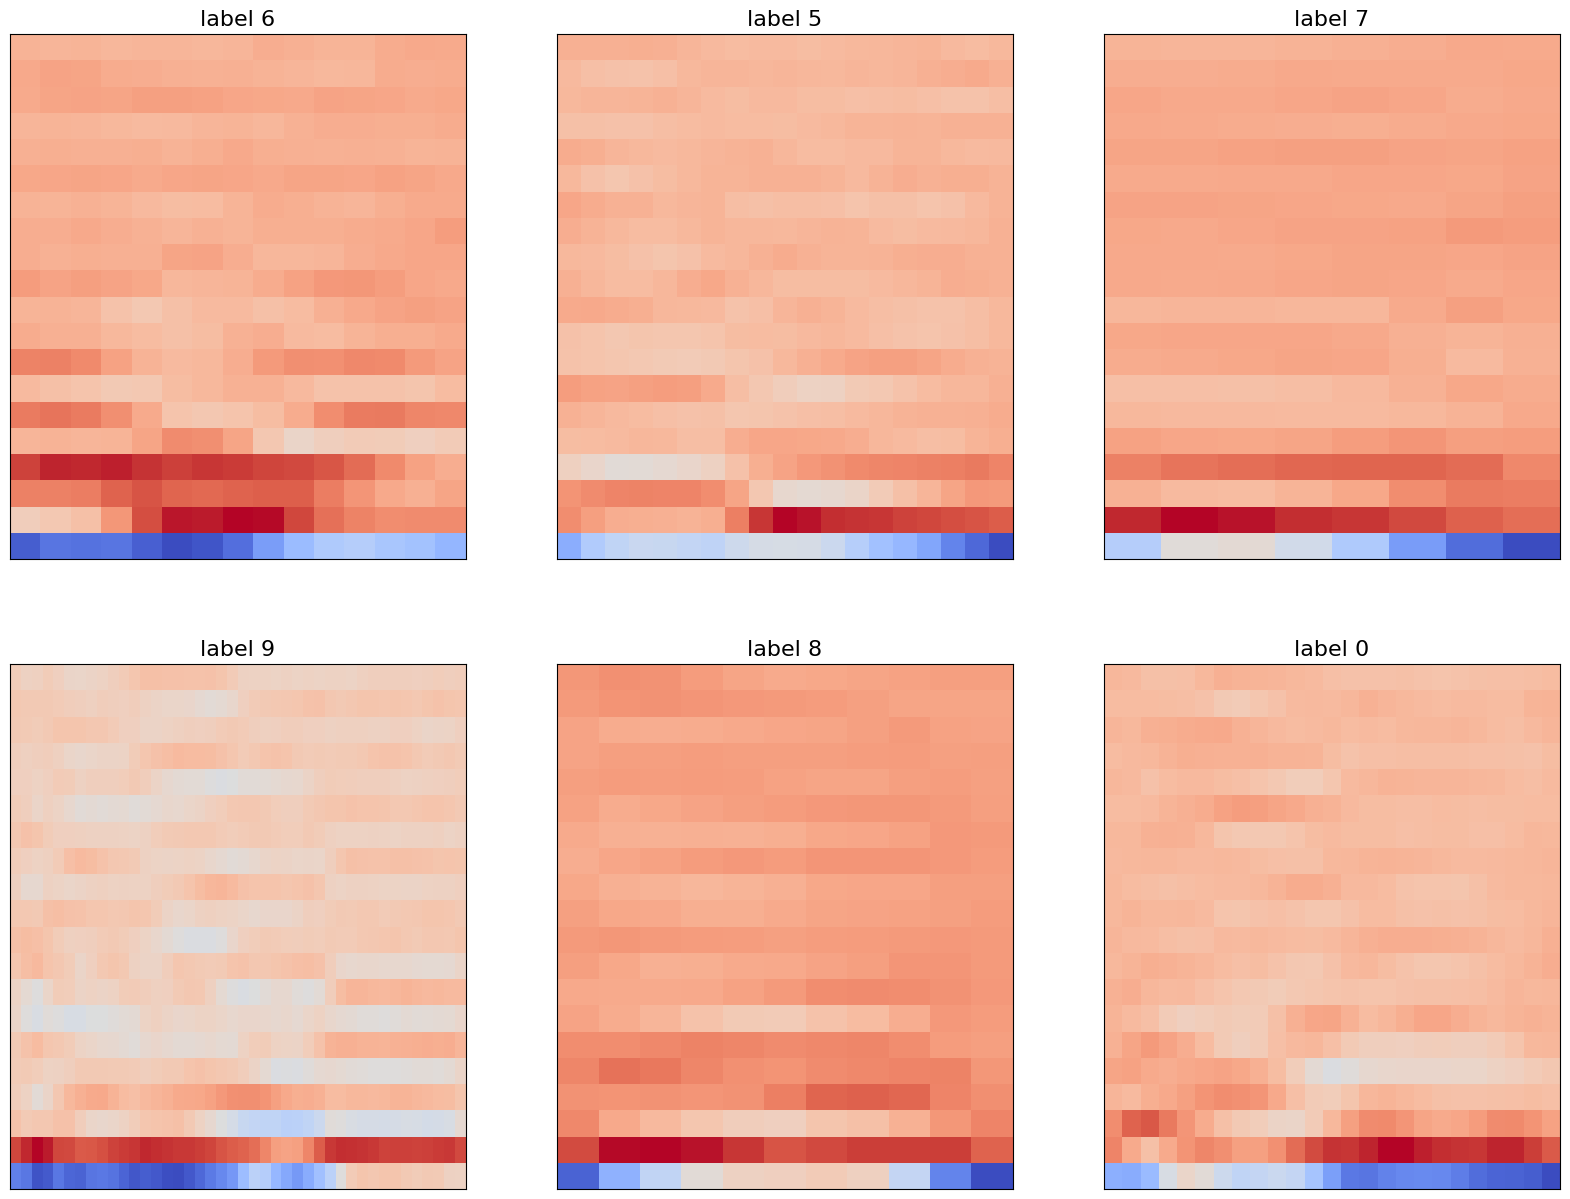

In [20]:
#On visualise le resultat du MFCC
num=6 
plt.figure(figsize=FIG_SIZE)
for i in range(6):
    plt.subplot(2,3,i+1)
    librosa.display.specshow(mfcc_audios2[i])
    plt.title(f"label {labels[i]}")

In [21]:
X=[]
X_2=[]
y=np.array(labels)

In [22]:
for mfcc in mfcc_audios:
    X.append(np.mean(mfcc, axis=1))

for mfcc in mfcc_audios2:
    X_2.append(np.mean(mfcc, axis=1))

X=np.array(X)
X_2=np.array(X_2)

## Division des données en Train-Valid-Test

In [23]:
# Diviser les données en ensembles d'entraînement et de test
X_train_1, X_tmp1, y_train_1, y_tmp1 = train_test_split(X, y, test_size=0.36, random_state=42)
X_train_2, X_tmp2, y_train_2, y_tmp2 = train_test_split(X_2, y, test_size=0.36, random_state=42)

#Diviser les données d'entrainement en ensemble d'entrainement et de validation
X_valid1, X_test1, y_valid1, y_test1= train_test_split(X_tmp1, y_tmp1, test_size=0.2/0.36, random_state=42)
X_valid2, X_test2, y_valid2, y_test2= train_test_split(X_tmp2, y_tmp2, test_size=0.2/0.36, random_state=42)

In [24]:
print("Methode de traitement 1")
print("-"*23)
print(f"Train : {X_train_1.shape}\nValid : {X_valid1.shape}\nTest : {X_test1.shape}")

Methode de traitement 1
-----------------------
Train : (1064, 20)
Valid : (266, 20)
Test : (334, 20)


In [25]:
print("Methode de traitement 2")
print("-"*23)
print(f"Train : {X_train_2.shape}\nValid : {X_valid2.shape}\nTest : {X_test2.shape}")

Methode de traitement 2
-----------------------
Train : (1064, 20)
Valid : (266, 20)
Test : (334, 20)


In [26]:
def pieplot(labels):
    labels_count=pd.Series(labels).value_counts()
    fig, ax = plt.subplots()
    ax.pie(labels_count, labels=labels_count.index, startangle=90, 
           autopct='%1.1f%%')
    ax.axis('equal')
    plt.show()

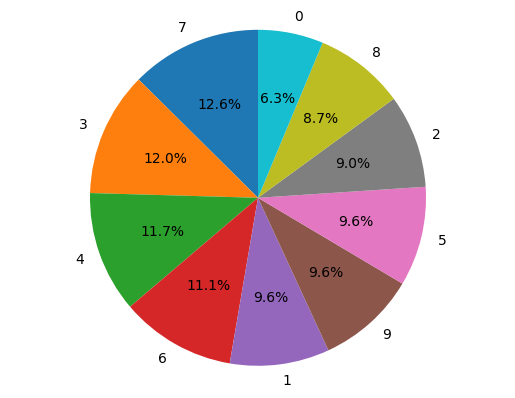

In [27]:
pieplot(y_test1)

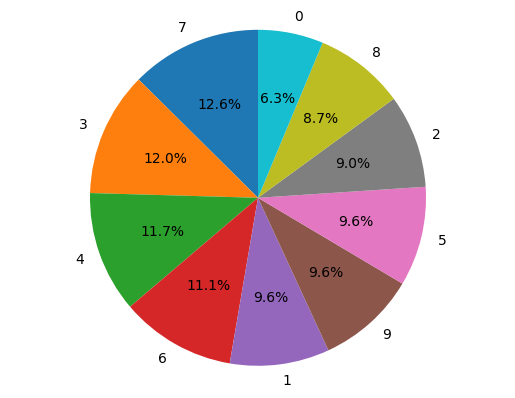

In [28]:
pieplot(y_test2)

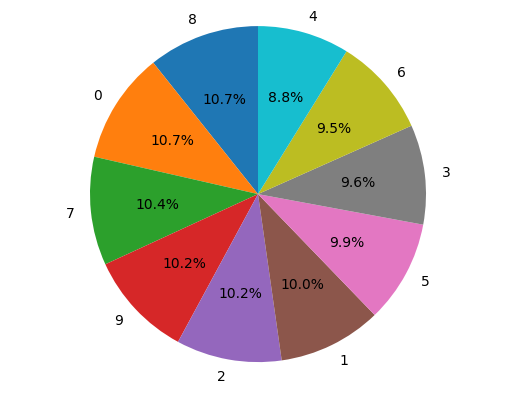

In [29]:
pieplot(y_train_1)

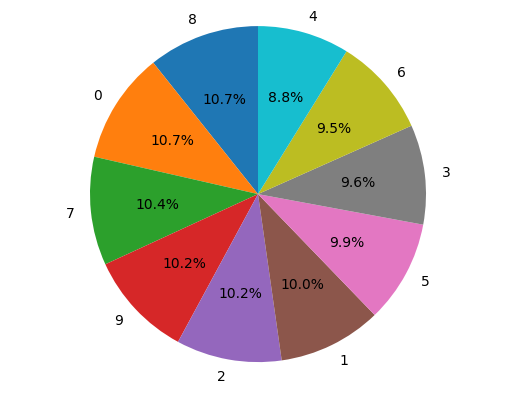

In [30]:
pieplot(y_train_2)

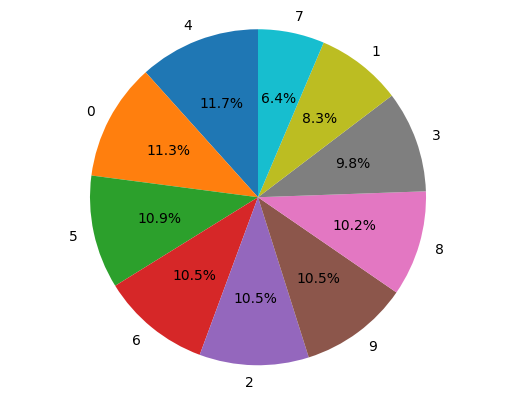

In [31]:
pieplot(y_valid1)

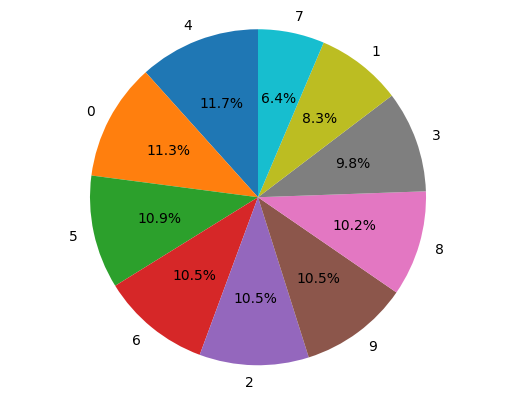

In [32]:
pieplot(y_valid2)

In [33]:
y_train_1 = to_categorical(y_train_1)
y_valid1 = to_categorical(y_valid1)
y_test1 = to_categorical(y_test1)

y_train_2 = to_categorical(y_train_2)
y_valid2 = to_categorical(y_valid2)
y_test2 = to_categorical(y_test2)

In [34]:
for i in range(3):
    print(y_train_1[i])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [35]:
for i in range(3):
    print(y_train_2[i])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Implémentation du modèle

### Construction du modèle

Avec tensorflow creer un modèle MPL revient a créer un objet qui Sequentiel au quel on peut ajouter des couches qui sont des couches denses c'est à dire que les neurones seront entièrement connecté \
Dans notre cas il aura 3 couches :
- Une couche dense de 128 neurones avec pour entré notre jeu de données Train
- Une seconde couche de 128 neurones connecté à la précedente
- Une Troisième couche dense de 10 neurones qui representera notre couche de sortie \
On remarque la couche d'entré mentionné dans l'architecture est implicitement substitué aux données d'entrées

In [36]:
#On instancie un objet Sequentiel
model = tf.keras.Sequential()

#On construit le modèle défini plus haut
model.add(Dense(128, activation='relu', input_shape=(X_train_1.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,  activation="softmax"))

#On visualise un résumé du modèle construit
model.summary()

/Users/macbookpro/miniforge3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,490 (80.04 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

### Compilation du modèle

A présent nous allons définir les paramètres d'apprentissage de notre modèle c'est à dire la métrique pour évaluer le modèle, la fonction d'optimisation et l'optimiseur. \
Dans le cadre de ce modèle nous allons utiliser :
- L'optimiseur : _RMSProp (Root Mean Square Propagation)_ qui est l'algorithme d'optimisation utilisé pour les réseau de neurone profond résolvant les problèmes du SGD (Stockastic Gradient Descent)
- La fonction de perte : _categorical_crossentropy_ car nos sortie sont des catégories à plus de deux classes et comme nous avions encoder nos données plus haut avec one hot nous ne pouvons donc pas utiliser le _sparse_categorical_crossentropy_ car il est adapté aux catégorie encodé par des chiffres (0, 1, 2, ...) ou _binary_crossentropy_ qui est adapté à la classification binaire.
- Metric : _accuracy_ qui va permettre de visualiser la qualité de l'apprentissage

In [37]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Entrainement du modèle

On ajoute le early stopping ici pour éviter le sur apprentissage du modèle

In [38]:
# On instancie EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
EPOCHS=50

In [39]:
# Entraînement du modèle avec EarlyStopping
training_results = model.fit(X_train_1,
                             y_train_1,
                             epochs=EPOCHS,
                             batch_size=10,
                             validation_data=(X_valid1, y_valid1),
                             callbacks=[early_stopping])

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1057 - loss: 12.2977 - val_accuracy: 0.1541 - val_loss: 6.1529
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2007 - loss: 4.9410 - val_accuracy: 0.2632 - val_loss: 4.0619
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2891 - loss: 3.7525 - val_accuracy: 0.1992 - val_loss: 4.5492
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3067 - loss: 3.1986 - val_accuracy: 0.2669 - val_loss: 3.1962
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3283 - loss: 2.6410 - val_accuracy: 0.2669 - val_loss: 3.0363
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3622 - loss: 2.3509 - val_accuracy: 0.2820 - val_loss: 2.6454
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3694 - loss: 2.1741 - val_accuracy: 0.3008 - val_loss: 2.4541
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4027 - loss: 1.9891 - val_accuracy: 0

In [40]:
#Visualisation des résultats de l'entrainement
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, EPOCHS])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

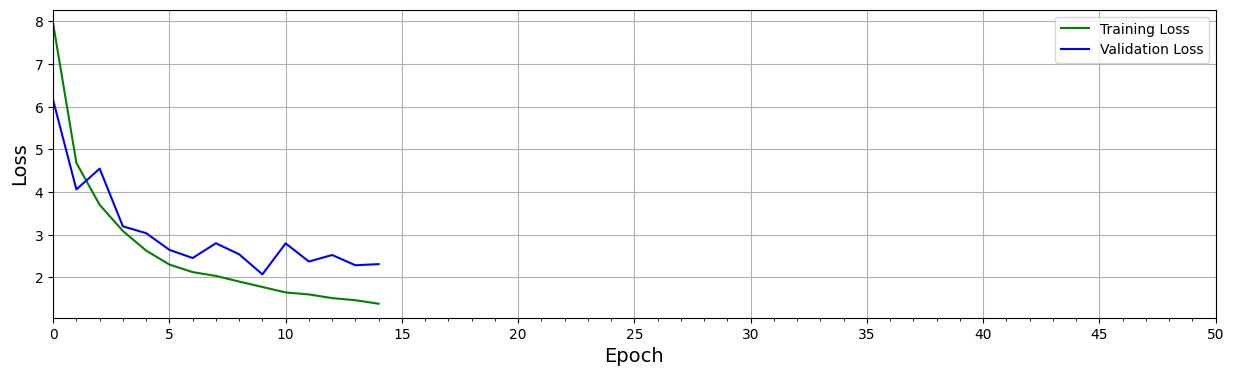

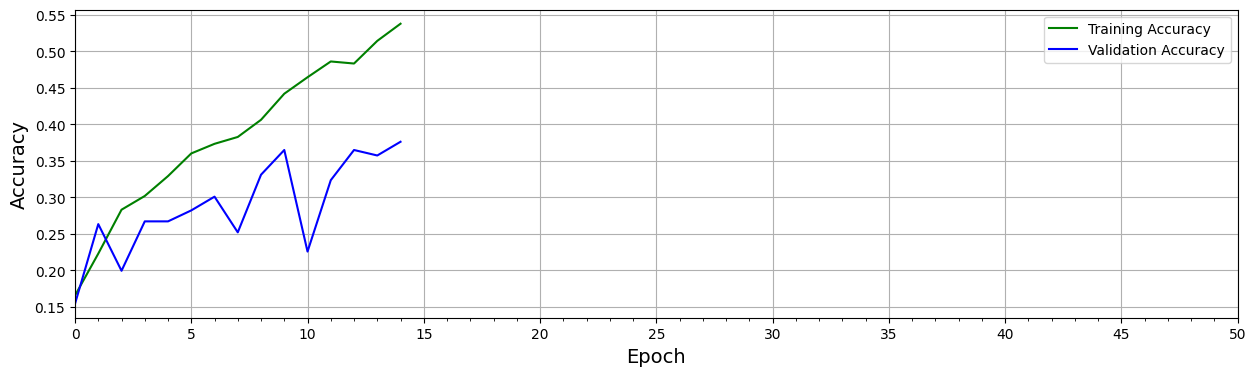

In [41]:
#Visualisation de la Loss et de l'Accuracy
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [42]:
train_acc[-1], valid_acc[-1]

(0.5375939607620239, 0.37593984603881836)

In [43]:
if valid_acc[-1]>=0.6:
    #Sauvegarde du modèle
    model.save(f'models/model_{valid_acc[-1]*100:.2f}_{str(datetime.datetime.now())}.h5')

### Evaluation du modèle

In [44]:
#Prediction avec les données de test
predictions = model.predict(X_test1)
index = np.random.randint(1,X_test1.shape[0])
print('Données réels du testset : ',y_test1[index])
print('\n');
print('Predictions pour chaque classe:\n')
for i in range(10):
    print('digit:', i, ' probabilité: ', predictions[index][i])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Données réels du testset :  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Predictions pour chaque classe:

digit: 0  probabilité:  0.005716906
digit: 1  probabilité:  0.056629606
digit: 2  probabilité:  0.010710181
digit: 3  probabilité:  0.020772982
digit: 4  probabilité:  0.036403798
digit: 5  probabilité:  0.015995488
digit: 6  probabilité:  0.11189898
digit: 7  probabilité:  0.014972888
digit: 8  probabilité:  0.598293
digit: 9  probabilité:  0.12860626


In [46]:
predicted_labels = [np.argmax(i) for i in predictions]
y_test_labels = [np.argmax(i) for i in y_test1]

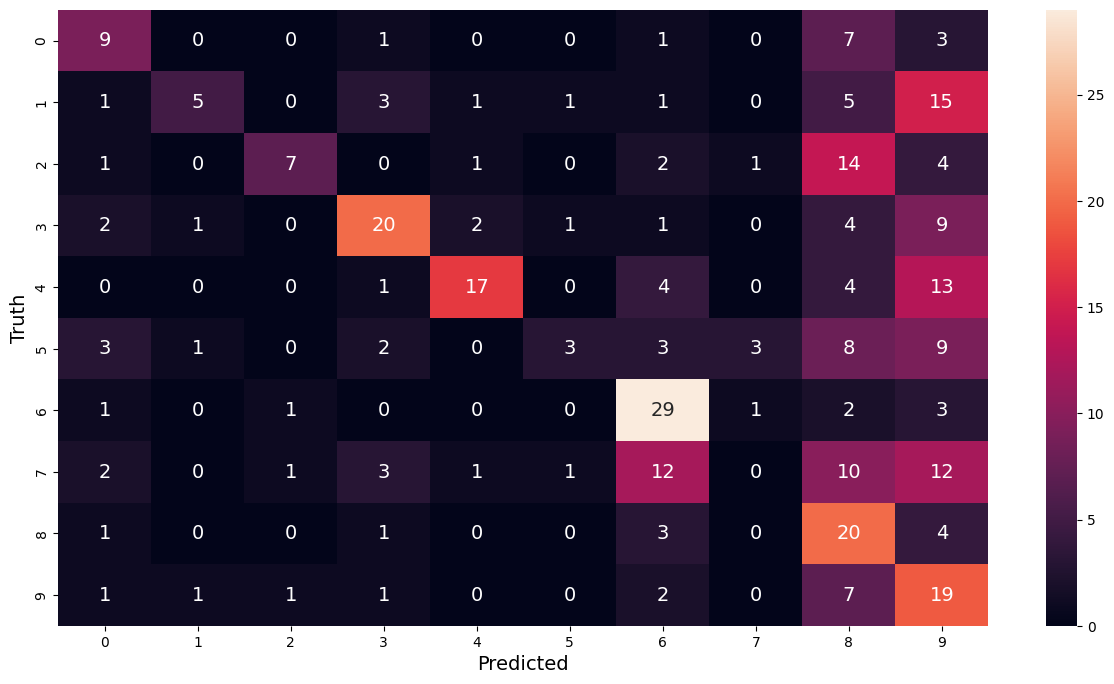

In [47]:
cm = tf.math.confusion_matrix(labels=y_test_labels, predictions=predicted_labels)

# Visualiser la matrice de confusion obtenue avec un heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()